### Import Necessary libraries

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

In [2]:
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms

### Train and Validation Dataset

To load the generate the data in required format, we can make use of dataset class.

In [3]:
def load_file(path):
    return np.load(path).astype(np.float32)

Next, we can define our train and validation transform:

In [4]:
# Transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.24),
    transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.24)
])

In [5]:
# Dataset

train_dataset = torchvision.datasets.DatasetFolder("./Processed/train", loader = load_file, extensions = "npy", transform = train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("./Processed/val/", loader = load_file, extensions = "npy", transform = val_transforms)

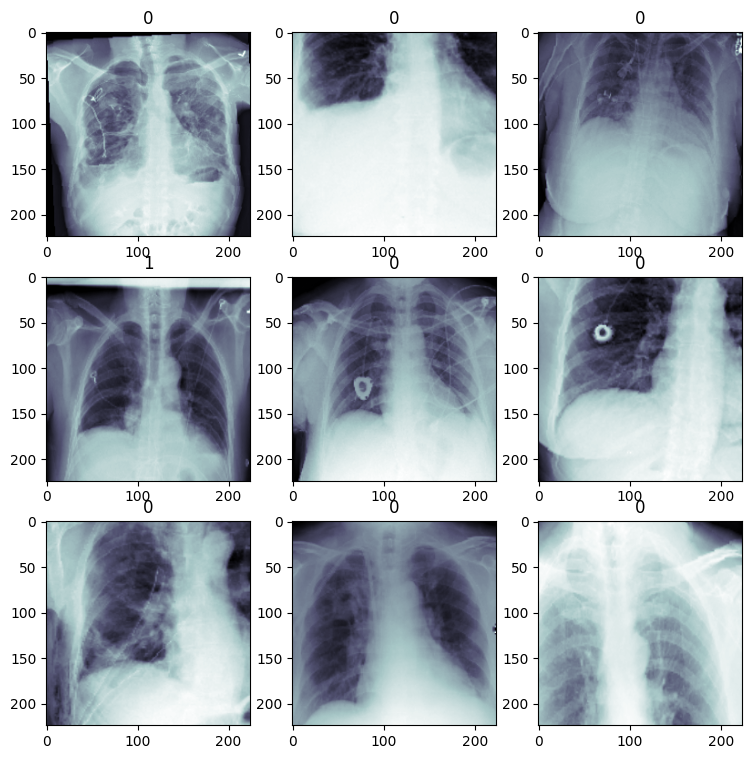

In [6]:
# Let's visualize 9 images from train dataset that are transformed 

fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

In [7]:
# Dataloader
batch_size = 16
num_workers = 6

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle=False)

In [8]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

### Model Architecture

The following code defines a PyTorch Lightning module called PneumoniaModel for a binary classification task of detecting pneumonia from chest X-rays. The model architecture used is `AlexNet`.

In [9]:
# Observing the Resnet18 architecture

torchvision.models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
class PneumoniaModel(pl.LightningModule):
    
    # Constructor
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.alexnet()
        self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.model.classifier[6] = torch.nn.Linear(in_features = 4096, out_features = 1, bias = True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")
        #self.test_acc = torchmetrics.Accuracy()
        
        
        
    # Activation
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

        
        
       
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return[self.optimizer]
    

In [11]:
model = PneumoniaModel()

In [12]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val ACC",
    save_top_k = 5,
    mode = "max",
    dirpath = "./AlexNet Output/saved_models"
)

In [13]:
# Configure the trainer
trainer = pl.Trainer(logger = TensorBoardLogger(save_dir = "./AlexNet Output/log"), log_every_n_steps = 64, callbacks = checkpoint_callback, max_epochs = 30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)

In [14]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
best_model = PneumoniaModel.load_from_checkpoint("./AlexNet Output/saved_models/epoch=29-step=45000.ckpt")

In [16]:
best_model.eval()

PneumoniaModel(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

In [17]:
best_model.to(device)

PneumoniaModel(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

In [18]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        
        # Calculate probabilities
        pred = torch.sigmoid(best_model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [19]:
# Accuracy
acc = torchmetrics.Accuracy(task = "binary")(preds, labels)

# Precision
precision = torchmetrics.Precision(task = "binary")(preds, labels)

# Recall
recall = torchmetrics.Recall(task = "binary")(preds, labels)

# Confusion Matrix
cm = torchmetrics.ConfusionMatrix(num_classes=2, task = "binary")(preds, labels)

# F-score 
f_score = (2*precision*recall)/(precision+recall)

In [20]:
print(f"Accuracy : {acc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"Confusion Matrix : {cm}")
print(f"F-score : {f_score}")

Accuracy : 0.7567064166069031
Precision : 0.477011501789093
Recall : 0.8231405019760132
Confusion Matrix : tensor([[1533,  546],
        [ 107,  498]])
F-score : 0.6040024161338806


### Class Activation Map

In [21]:
model = torchvision.models.alexnet()

In [22]:
list(model.children())[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [23]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.alexnet()
        self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=1, bias=True)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[0])
        
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input = feature_map, output_size=(6, 6))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.classifier(avg_output_flattened)
        return pred, feature_map

In [24]:
model = PneumoniaModel.load_from_checkpoint("./AlexNet Output/saved_models/epoch=29-step=45000.ckpt", strict = False)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:158: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.0.bias', 'feature_map.3.weight', 'feature_map.3.bias', 'feature_map.6.weight', 'feature_map.6.bias', 'feature_map.8.weight', 'feature_map.8.bias', 'feature_map.10.weight', 'feature_map.10.bias']
  rank_zero_warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:162: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss_fn.pos_weight']
  rank_zero_warn(


In [25]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0).to(device))
        pred, features = pred.to(device), features.to(device)
    features = features.reshape((256, 36))
    weight_params = list(model.model.classifier.parameters())[0][1].reshape(36, 256)
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(6, 6).cpu()
    return cam_img, torch.sigmoid(pred)

In [26]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap = 'bone')
    axis[1].imshow(img, cmap= 'bone')
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>0.5)

In [27]:
val_dataset[-6][0].shape

torch.Size([1, 224, 224])

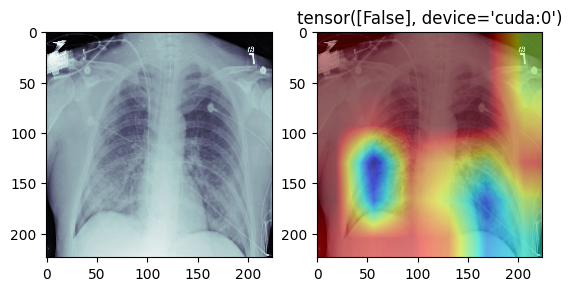

In [28]:
img = val_dataset[-6][0]
activation_map, pred = cam(model, img)
visualize(img, activation_map, pred)